In [111]:
%pip install -qU pandas matplotlib seaborn python-dotenv requests

Note: you may need to restart the kernel to use updated packages.


In [112]:
import pandas as pd

# .csv to pandas df
imdb_soundtracks = pd.read_csv("../data/sound_track_imdb_top_250_movie_tv_series.csv")
imdb_soundtracks.head()

,Unnamed: 0,name,year,song_name,written_by,performed_by,composed_by,lyrics_by,written_performed_by,music_by,courtesy_of,conducted_by,libretto_by,under_license_from
0,0,The Shawshank Redemption,1994,If I Didn't Care,NaN,The Ink Spots,NaN,NaN,NaN,NaN,MCA Records,NaN,NaN,NaN
1,1,The Shawshank Redemption,1994,Duettino - Sull'aria,NaN,Edith Mathis (uncredited) and Gundula Janowitz...,Wolfgang Amadeus Mozart,NaN,NaN,NaN,NaN,Karl Böhm,Lorenzo da Ponte (uncredited),NaN
2,2,The Shawshank Redemption,1994,Put The Blame On Mame,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,The Shawshank Redemption,1994,Lovesick Blues,NaN,Hank Williams,NaN,NaN,NaN,NaN,PolyGram Special Markets,NaN,NaN,NaN
4,4,The Shawshank Redemption,1994,Willie and The Hand Jive,NaN,NaN,NaN,NaN,NaN,NaN,Capitol Records,NaN,NaN,CEMA Special Markets


Unnamed: 0                 0
name                       0
year                       0
song_name                  0
written_by              1622
performed_by            1472
composed_by             2902
lyrics_by               2877
written_performed_by    3020
music_by                2651
courtesy_of             2069
conducted_by            3026
libretto_by             3122
under_license_from      2976
dtype: int64


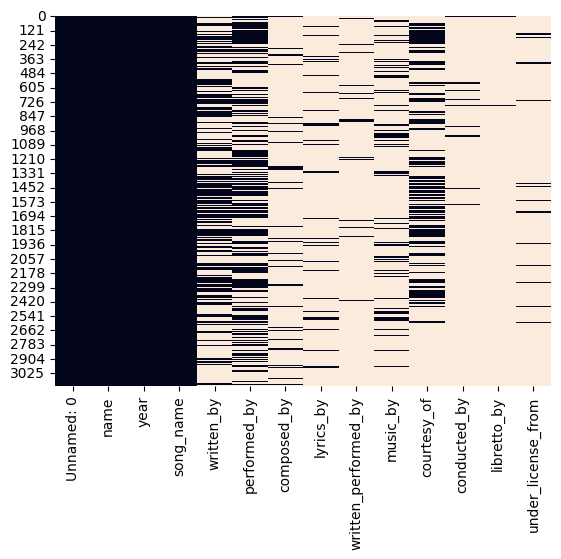

In [113]:
import seaborn as sns 
import matplotlib.pyplot as plt 

# Visualize null columns to see which fields are unnecessary
sns.heatmap(imdb_soundtracks.isnull(), cbar=False)
print(imdb_soundtracks.isna().sum())
plt.show()

In [114]:
# Drop unnecessary fields
imdb_soundtracks = imdb_soundtracks.drop(columns=['written_performed_by', 'conducted_by', 'libretto_by', 'under_license_from'])

imdb_soundtracks.drop(imdb_soundtracks[imdb_soundtracks['song_name'] == "It looks like we don't have any Soundtracks for this title yet."].index, inplace = True)

# Convert to string to use for Spotify API search
imdb_soundtracks['performed_by'] = imdb_soundtracks['performed_by'].fillna("nan").astype(str)

In [126]:
from dotenv import load_dotenv
import os
from requests import post, get
import base64
import json
from urllib.parse import quote

load_dotenv()

client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

# print(client_id)
# print(client_secret)

# Token needed to search Spotify API
def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    result = post(url, headers=headers, data=data)

    json_result = json.loads(result.content)
    return json_result["access_token"]


In [127]:
def make_url(song_name, artist_name):
    url = "https://api.spotify.com/v1/search"
    song_name = song_name[:50]
    if(artist_name == "nan"):
        query = f'track:"{song_name}"'
    else:
        artist_name = artist_name[:50]
        query = f'track:"{song_name}" artist:"{artist_name}"'

    query = quote(query)
    query_url = f"{url}?q={query}&type=track&limit=1"
    return query_url

In [ ]:
def song_data(json_result):
    title = json_result['name']
    artist = json_result['artists'][0]['name']
    album = json_result['album']['name']
    spotify_id = json_result['id']


In [131]:
def search_track(token, song_name, artist_name):
    headers = {"Authorization": "Bearer " + token}

    query_url = make_url(song_name, artist_name)
    print(query_url)
    result = get(query_url, headers=headers)
    #print(json.loads(result.content))
    json_result = json.loads(result.content)["tracks"]["items"]

    if len(json_result) == 0 and artist_name != "nan":
        print("Trying again with only song name...")
        print(query_url)
        query_url = make_url(song_name, "nan")  
        result = get(query_url, headers=headers)
        json_result = json.loads(result.content)["tracks"]["items"]

    if len(json_result) == 0:
        print("No track found")
        return None
    
    data = song_data(json_result[0])
    return data

token = get_token()
# print(token)

In [ ]:
result = search_track(token, "Get Care for Me", "nan")
print(result.keys())
print(result['name'])

In [129]:
imdb_soundtracks.iat[0, 5]
result = search_track(token, imdb_soundtracks.iat[4, 3], imdb_soundtracks.iat[4, 5])
print(result.keys())
print(result['name'])

https://api.spotify.com/v1/search?q=track%3A%22Willie%20and%20The%20Hand%20Jive%20%22&type=track&limit=1
dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'is_playable', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])
Willie And The Hand Jive


In [ ]:
spotify_soundtrack_results = []

In [119]:
start = 0

for index, row in imdb_soundtracks.iloc[start:].iterrows(): 
    song_name = row['song_name']
    artist_name = row['performed_by']
    print(f'Get {song_name} by {artist_name}')
    
    data = search_track(token, song_name, artist_name)

    spotify_soundtrack_results.append(data)

Get If I Didn't Care  by The Ink Spots 
https://api.spotify.com/v1/search?q=track%3A%22If%20I%20Didn%27t%20Care%20%22%20artist%3A%22The%20Ink%20Spots%20%22&type=track&limit=1
Get Duettino - Sull'aria  by Edith Mathis (uncredited) and Gundula Janowitz (uncredited) Chor und Orchester der Deutschen Oper Berlin 
https://api.spotify.com/v1/search?q=track%3A%22Duettino%20-%20Sull%27aria%20%22%20artist%3A%22Edith%20Mathis%20%28uncredited%29%20and%20Gundula%20Janowitz%20%28un%22&type=track&limit=1
Trying again with only song name...
https://api.spotify.com/v1/search?q=track%3A%22Duettino%20-%20Sull%27aria%20%22%20artist%3A%22Edith%20Mathis%20%28uncredited%29%20and%20Gundula%20Janowitz%20%28un%22&type=track&limit=1
Get Put The Blame On Mame  by nan
https://api.spotify.com/v1/search?q=track%3A%22Put%20The%20Blame%20On%20Mame%20%22&type=track&limit=1
Get Lovesick Blues  by Hank Williams 
https://api.spotify.com/v1/search?q=track%3A%22Lovesick%20Blues%20%22%20artist%3A%22Hank%20Williams%20%22&type

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [130]:
import pickle

with open('../data/spotify-soundtrack-results.pkl', 'wb') as f:
    pickle.dump(spotify_soundtrack_results, f)

In [33]:
spotify_soundtracks = pd.DataFrame(spotify_soundtrack_results)
spotify_soundtracks

AttributeError: 'NoneType' object has no attribute 'keys'

In [ ]:
imdb_soundtracks = pd.concat([imdb_soundtracks, spotify_soundtracks], axis=1)
imdb_soundtracks